In [1]:
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import calendar
import datetime
from datetime import *
pd.options.display.max_rows = 20
pd.options.display.max_columns = 999
import pandas_profiling as pp
import random
#pip install pandas-profiling

### I. Import data

In [2]:
#Import data from Excecl
df = pd.read_excel(r'C:\Users\Mycomputer\Documents\Python Scripts\KV\App Rating\211102_AppRating_KV.xlsx')
df.head(3)

,date,rating,id,content
0,2021-08-27,1,1630035830790,Nhập đúng tên đăng nhập với mật khẩu mà cứ báo...
1,2021-08-03,1,1627980064551,Out ra liên tục rồi k thể vào lại được là sao
2,2021-08-10,1,1628608463328,App quá tệ nói dùng thử mà dùng thử vẫn không ...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2654 entries, 0 to 2653
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     2654 non-null   datetime64[ns]
 1   rating   2654 non-null   int64         
 2   id       2654 non-null   int64         
 3   content  1428 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 83.1+ KB


In [4]:
df.describe()

,rating,id
count,2654.000000,2.654000e+03
mean,3.803316,1.367464e+12
std,1.602783,5.327523e+11
min,1.000000,1.457445e+09
25%,3.000000,1.515286e+12
50%,5.000000,1.573111e+12
75%,5.000000,1.606285e+12
max,5.000000,1.635565e+12


In [5]:
#Checking for nulls
df.isnull().sum()

date          0
rating        0
id            0
content    1226
dtype: int64

In [6]:
#Loại các trường hợp null content
df = df.loc[~df.content.isna()]
df.head()

,date,rating,id,content
0,2021-08-27,1,1630035830790,Nhập đúng tên đăng nhập với mật khẩu mà cứ báo...
1,2021-08-03,1,1627980064551,Out ra liên tục rồi k thể vào lại được là sao
2,2021-08-10,1,1628608463328,App quá tệ nói dùng thử mà dùng thử vẫn không ...
3,2021-10-27,1,1635294460184,"Hay lag, đứng hình, or ko ra bill, hay lỗi bil..."
7,2021-10-21,1,1634791504242,Đăng nhập thì cứ bị văng ra. Nhân viên gọi mìn...


### II. Xem phân phối

#### 1. Avg words trong mỗi bài đáng giá

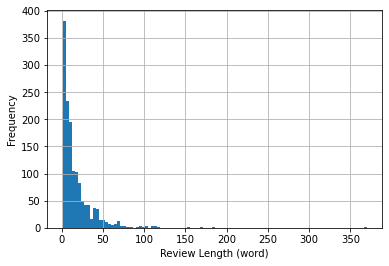

In [7]:
#Getting the number of words by splitting them by a space
words_per_review = df.content.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100)

plt.xlabel('Review Length (word)')
plt.ylabel('Frequency')
plt.show()

In [8]:
print('Average words:', words_per_review.mean())
print('Skewness:', words_per_review.skew())

Average words: 17.121148459383754
Skewness: 4.932708358849552


=> Số lượng từ trên mỗi bài đánh giá của người dùng (words_per_review) có độ lệch dương (positive skewness) với trung bình là 17, tức trung bình người dùng đánh giá 17 từ

#### 2. Distribution of ratings

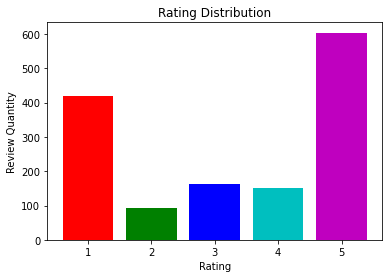

In [9]:
#Seperating by groups
groups = df.groupby('rating').count()
Values = groups.content
colors = ['r', 'g', 'b', 'c', 'm']

#Making bar plot
plt.bar(([1,2,3,4,5]), Values, color= colors)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Review Quantity')
plt.show()

In [10]:
#Rating ratio
percent_val = 100 * df['rating'].value_counts()/len(df)
percent_val

5    42.296919
1    29.341737
3    11.414566
4    10.504202
2     6.442577
Name: rating, dtype: float64

=> Sự phân bố khá lệch, với 1 số lượng lớn ở 5 sao và rất ít ở 3, 4, 2 sao

In [11]:
#Mapping the rating (creating new binary_class column)
df['binary_class'] = np.where(df['rating'] > 3, 1, 0)

#Printing the counts of each class
df['binary_class'].value_counts()

1    754
0    674
Name: binary_class, dtype: int64

#### 3. Words Cloud

In [12]:
## pip install wordcloud
from wordcloud import WordCloud

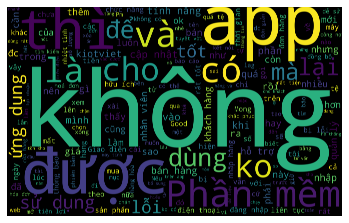

In [13]:
word_cloud_text = ' '.join(df['content'])
wordCloud = WordCloud(max_font_size = 250,            # Maximum font size for the largest word
                      background_color = "black",     # Background color for the word cloud image
                      scale = 10,                     # Scaling between computation and drawing
                      width = 800,                    # Width of the canvas
                      height = 500,                   # Height of the canvas
                      random_state = 21
                     ).generate(word_cloud_text)

plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

=> Một số từ xuất hiện nhiều nhưng không có ý nghĩa trong việc phân tích như: là, mà, và, thì, có, kiotviet, trong, để,...

### III. Pre-processing

In [14]:
#Import regex
import regex as re

#### 1. Chuẩn hóa bảng mã tiếng Việt

In [15]:
#Chuẩn hóa bảng mã tiếng Việt

uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"
 

def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
 
dicchar = loaddicchar()
 
#Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại 
def covert_unicode(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

#Apply function
df['content_fix'] = df['content'].apply(lambda txt: covert_unicode(txt))
df['content_fix'].head()

0    Nhập đúng tên đăng nhập với mật khẩu mà cứ báo...
1        Out ra liên tục rồi k thể vào lại được là sao
2    App quá tệ nói dùng thử mà dùng thử vẫn không ...
3    Hay lag, đứng hình, or ko ra bill, hay lỗi bil...
7    Đăng nhập thì cứ bị văng ra. Nhân viên gọi mìn...
Name: content_fix, dtype: object

#### 2. Đưa chữ cái về dạng lower

In [16]:
def lower(l):
    return l.lower()
df['content_fix'] = df['content_fix'].apply(lambda l: lower(l))
df['content_fix'].head()

0    nhập đúng tên đăng nhập với mật khẩu mà cứ báo...
1        out ra liên tục rồi k thể vào lại được là sao
2    app quá tệ nói dùng thử mà dùng thử vẫn không ...
3    hay lag, đứng hình, or ko ra bill, hay lỗi bil...
7    đăng nhập thì cứ bị văng ra. nhân viên gọi mìn...
Name: content_fix, dtype: object

#### 3. Chuẩn hóa từ viết tắt và English words

In [17]:
#List từ chuẩn hóa
replace_list = {
    ' okie ': ' ok ', ' o kê ': ' ok ', ' okey ': ' ok ', ' oki ': ' ok ', ' oke ': ' ok ', ' okay ':' ok ', ' okê ':' ok ', ' okk ':' ok ',
    ' kg ': u' không ', ' not ': u' không ', ' k ': u' không ', ' ko ': u' không ', 'ko': u' không ', ' kh ':u' không ',' hok ':u' không ', u'không ':u' không ', ' khong ':u' không ',
    u' đx ': u' được ', ' dk ': u' được ', ' dc ': u' được ', ' dc': u' được ', ' đk ': u' được ', ' đc ': u' được ',
    ' good ': u' tốt ', 'good': u' tốt ', u' tot ': u' tốt ', u'tot ': u' tốt ', u'tot': u' tốt ', u' nice ': u' tốt ', ' perfect ' : ' rất tốt ', ' great ': ' rất tuyệt ', 'great ': ' rất tuyệt ', 'great': ' rất tuyệt ',
    ' thik ': u' thích ', u' thic ': u' thích ', u' like ': u' thích ',
    ' bad ': ' tệ ', ' lol ': ' tệ ', ' l ': ' tệ ', ' cc ': ' tệ ', ' cc': ' tệ ', ' shit ': ' tệ ',
    ' app ': ' ứng dụng ', 'app ': ' ứng dụng ', ' tien ich ': ' tiện ích ', ' huu ich ': ' hữu ích ', u' đt ': ' điện thoại '
    } 

df['content_fix'] = df['content_fix'].replace(replace_list, regex=True)

#### 4. Xóa các số, ký tự không cần thiết, khoảng trắng thừa

In [18]:
#Create a function to clean the content
def cleanTxt(text):
    text = re.sub(r"[0-9]",' ',text)                    #Xóa các số
    text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',text) #Xóa các ký tự không cần thiết
    text = re.sub(r'\s+', ' ', text).strip()           #Xóa các khoảng trắng thừa
    return text

#Cleaning
df['content_fix'] = df['content_fix'].apply(cleanTxt)

#Show the cleaned text
df['content_fix'] = df.content_fix.str.replace("_",'')
df['content_fix'].head()

0    nhập đúng tên đăng nhập với mật khẩu mà cứ báo...
1    out ra liên tục rồi không thể vào lại được là sao
2    ứng dụng quá tệ nói dùng thử mà dùng thử vẫn k...
3    hay lag đứng hình or không ra bill hay lỗi bil...
7    đăng nhập thì cứ bị văng ra nhân viên gọi mình...
Name: content_fix, dtype: object

#### 5. Stopwords with high/low frequency words

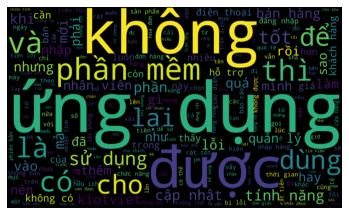

In [19]:
#Check words cloud với data content sau khi được làm sạch
word_cloud = ' '.join(df['content_fix'])
wordCloud_new = WordCloud(max_font_size = 250,        # Maximum font size for the largest word
                      background_color = "black",     # Background color for the word cloud image
                      scale = 10,                     # Scaling between computation and drawing
                      width = 500,                    # Width of the canvas
                      height = 300,                   # Height of the canvas
                      random_state = 21
                     ).generate(word_cloud)

plt.imshow(wordCloud_new, interpolation = "bilinear")
plt.axis('off')
plt.show()

In [20]:
#Top 20 the common words
pd.Series(' '.join(df.content_fix).split()).value_counts().head(20)

không    638
dụng     509
hàng     488
ứng      378
được     369
có       321
phần     295
rất      256
tốt      220
cho      218
dùng     211
lỗi      202
và       200
thì      194
nhập     194
mềm      187
trên     180
là       177
năng     171
mình     170
dtype: int64

=> Chọn các từ xuất hiện nhiều nhưng không có ý nghĩa trong việc phân tích sentiment gồm: có, rất, cho, và, thì, là, mà, kiotviet, trong, để, này, như

In [21]:
#Create list stopwords
stop_words = ['có', 'rất', 'cho', 'và', 'thì', 'là', 'mà', 'kiotviet', 'trong', 'ạ', 'nữa', 'bị', 'dùng', 'phần', 'trên', 'dưới',
              'để', 'này', 'như', 'mình', 'khi', 'lại', 'rồi', 'sẽ', 'nên', 'của', 'vào', 'ra', 'các', 'nhưng', 'cũng', 'với',
              'nếu', 'quá', 'à', 'đó', 'đấy', 'đã', 'gì', 'vẫn', 'tôi', 'còn', 'luôn', 'lên', 'chỉ', 'phải', 'được'
             ]

#### 6. Tokenization

In [22]:
## pip install vncorenlp
from vncorenlp import VnCoreNLP

In [23]:
vncorenlp_file =  VnCoreNLP(r'C:\Users\Mycomputer\Documents\Python Scripts\CoreNLP\VnCoreNLP-1.1.jar', annotators="wseg,pos,ner,parse", max_heap_size='-Xmx2g')

In [24]:
#Create function Tokenization
def preprocessing(t):
    result_pre = vncorenlp_file.tokenize(t)
    return result_pre
## pos_tag

In [25]:
#Tách từ tiếng việt
df['word_segmentation'] = df['content_fix'].apply(lambda t: preprocessing(t))

###### Combine the words from list to list into sentences

In [26]:
import itertools

In [27]:
#Kết hợp thành câu
ls = df['word_segmentation']

def join(ls):
    merged = list(itertools.chain.from_iterable(ls))
    new_join = ' '.join(merged)
    return new_join

df['word_segmentation'] = df['word_segmentation'].apply(lambda ls: join(ls))

#### 7. Reject stopwords

In [28]:
## install nltk
from nltk.tokenize import word_tokenize
import nltk

In [29]:
#Tạo hàm remove stop word: nhận vào 1 câu và xuất ra 1 câu kết quả
text = df['word_segmentation']

def remove_stop_words(text):
    tokens  = [word for word in word_tokenize(text) if not word in stop_words]
    new_text = ' '.join(tokens)
    return new_text

#df['word_segmentation'].apply(lambda text: remove_stop_words(text))

In [30]:
#lấy list reviews
list_review = df['word_segmentation'].tolist()

#Khai báo list kết quả
list_filtered_sentence = [] 

#For loop các reviews tạo ra từng kết quả tương ứng
for r in list_review: 
    filtered_review = remove_stop_words(r)
    list_filtered_sentence.append(filtered_review)

#Gán lại kết quả vào cột mới
df['word_segmentation'] = list_filtered_sentence

In [31]:
df.head(3)

,date,rating,id,content,binary_class,content_fix,word_segmentation
0,2021-08-27,1,1630035830790,Nhập đúng tên đăng nhập với mật khẩu mà cứ báo...,0,nhập đúng tên đăng nhập với mật khẩu mà cứ báo...,nhập đúng tên đăng_nhập mật_khẩu cứ báo lỗi đă...
1,2021-08-03,1,1627980064551,Out ra liên tục rồi k thể vào lại được là sao,0,out ra liên tục rồi không thể vào lại được là sao,out liên_tục không_thể sao
2,2021-08-10,1,1628608463328,App quá tệ nói dùng thử mà dùng thử vẫn không ...,0,ứng dụng quá tệ nói dùng thử mà dùng thử vẫn k...,ứng_dụng tệ nói thử thử không kết_quả nói trun...


### IV. Building a ML model

#### 1. Chuẩn hóa rating cho phân tích

Để giúp train model tốt hơn, chuyển 5 loại xếp hạng về thành 2 class (0,1)
- Xếp hạng dưới 3 sao là 0 (negative)
- Xếp hạng từ 4 trở lên sao là 1 (positive)
- Xếp hạng = 3 là neutral nên loại bỏ để mô hình chạy tốt hơn

In [32]:
#Removeing neutral review (rating = 3)
df_new = df[df.rating != 3]

#Mapping the rating (creating new binary_class column)
df_new['sentiment_rating'] = np.where(df_new['rating'] > 3, 1, 0)

#Printing the counts of each class
df_new['sentiment_rating'].value_counts()

<ipython-input-32-72030cb78851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['sentiment_rating'] = np.where(df_new['rating'] > 3, 1, 0)


1    754
0    511
Name: sentiment_rating, dtype: int64

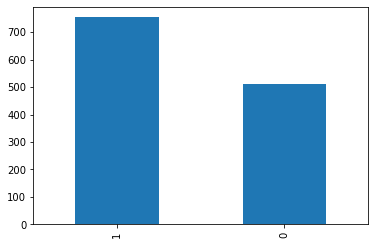

In [33]:
df_new['sentiment_rating'].value_counts().plot.bar()
plt.show()

=> Dữ liệu thu được không có sự chênh lệch đáng kể về số lượng, tuy nhiên vẫn có imbalance nhẹ

In [34]:
df_new = df_new[['word_segmentation', 'rating','sentiment_rating']]
df_new.head(5)

,word_segmentation,rating,sentiment_rating
0,nhập đúng tên đăng_nhập mật_khẩu cứ báo lỗi đă...,1,0
1,out liên_tục không_thể sao,1,0
2,ứng_dụng tệ nói thử thử không kết_quả nói trun...,1,0
3,hay lag đứng hình or không bill hay lỗi bill s...,1,0
7,đăng_nhập cứ văng nhân_viên gọi nói không nhu_...,1,0


####  2. Train/Test Split

In [35]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [36]:
#train/test split
from sklearn.model_selection import train_test_split

X_train_words, X_test_words, y_train_words, y_test_words = train_test_split(df['word_segmentation'], df['binary_class'], test_size=0.2, random_state = 0)

In [37]:
#Importing countvectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Creating variable which assigns X_train to numbers (2 words)
vect_w = CountVectorizer(tokenizer= word_tokenize,        # type of tokenization
                       stop_words= stop_words,          # list of stopwords
                       ngram_range=(1,2)                # nb of n-grams
                      ).fit(X_train_words)

#Translates numbers back to text
vect_w.get_feature_names()[1:10]

#Creating matrix array 
X_train_words = vect_w.transform(X_train_words)
print (X_train_words.toarray())

#Creating log regression
from sklearn.linear_model import LogisticRegression

nb_words_model = LogisticRegression(C=1,max_iter=200)
nb_words_model.fit(X_train_words, y_train_words)

#Predicting the output
test_pred_nb_words = nb_words_model.predict(vect_w.transform(X_test_words))

#Calulate key performance metrics
print("Accuracy_score: ", accuracy_score(y_test_words, test_pred_nb_words))
print("F1_score: ", f1_score(y_test_words, test_pred_nb_words))

C:\Users\Mycomputer\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Accuracy_score:  0.8321678321678322
F1_score:  0.8431372549019608


In [38]:
#Splitting into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_new['word_segmentation'], df_new['sentiment_rating'], test_size=0.2, random_state = 0)

In [39]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1012,), (253,), (1012,), (253,))

In [40]:
#Importing countvectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Creating variable which assigns X_train to numbers (2 words)
vect = CountVectorizer(tokenizer= word_tokenize,        # type of tokenization
                       stop_words= stop_words,          # list of stopwords
                       ngram_range=(1,2)                # nb of n-grams
                      ).fit(X_train)

#Translates numbers back to text
vect.get_feature_names()[1:10]

#Creating matrix array 
X_train = vect.transform(X_train)
print (X_train.toarray())

C:\Users\Mycomputer\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


####  3. Training Model

In [41]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

##### a. Navie Bayes

In [42]:
#Creating Naive Bayes
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

#Predicting the output
test_pred_nb = nb_model.predict(vect.transform(X_test))

#Calulate key performance metrics
print("Accuracy_score: ", accuracy_score(y_test, test_pred_nb))
print("F1_score: ", f1_score(y_test, test_pred_nb))
print(confusion_matrix(y_test,test_pred_nb))
print(classification_report(y_test,test_pred_nb))

Accuracy_score:  0.8735177865612648
F1_score:  0.8888888888888888
[[ 93   4]
 [ 28 128]]
              precision    recall  f1-score   support

           0       0.77      0.96      0.85        97
           1       0.97      0.82      0.89       156

    accuracy                           0.87       253
   macro avg       0.87      0.89      0.87       253
weighted avg       0.89      0.87      0.88       253



##### b. Logistic Regression

In [43]:
#Creating log regression
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(C=1,max_iter=200)
lr_model.fit(X_train, y_train)

#Predicting the output
test_pred_lr = lr_model.predict(vect.transform(X_test))

#Calulate key performance metrics
print("Accuracy_score: ", accuracy_score(y_test, test_pred_lr))
print("F1_score: ", f1_score(y_test, test_pred_lr))
print(confusion_matrix(y_test,test_pred_lr))
print(classification_report(y_test,test_pred_lr))

Accuracy_score:  0.857707509881423
F1_score:  0.881578947368421
[[ 83  14]
 [ 22 134]]
              precision    recall  f1-score   support

           0       0.79      0.86      0.82        97
           1       0.91      0.86      0.88       156

    accuracy                           0.86       253
   macro avg       0.85      0.86      0.85       253
weighted avg       0.86      0.86      0.86       253



##### c. Random Forest

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [45]:
#Creating Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=0)
rf_model.fit(X_train, y_train)

#Predicting the output
test_pred_rf = rf_model.predict(vect.transform(X_test))

#Calulate key performance metrics
print("Accuracy_score: ", accuracy_score(y_test, test_pred_rf))
print("F1_score: ", f1_score(y_test, test_pred_rf))
print(confusion_matrix(y_test,test_pred_rf))
print(classification_report(y_test,test_pred_rf))

Accuracy_score:  0.849802371541502
F1_score:  0.8716216216216216
[[ 86  11]
 [ 27 129]]
              precision    recall  f1-score   support

           0       0.76      0.89      0.82        97
           1       0.92      0.83      0.87       156

    accuracy                           0.85       253
   macro avg       0.84      0.86      0.85       253
weighted avg       0.86      0.85      0.85       253



##### d. Support Vector Machine (SVM)

In [46]:
#Creating SVM
from sklearn import svm
from sklearn.svm import SVC

svc_model = SVC(kernel='linear')
svc_model.fit(X_train, y_train)

#Predicting the output
test_pred_svc = svc_model.predict(vect.transform(X_test))

#Calulate key performance metrics
print("Accuracy_score: ", accuracy_score(y_test, test_pred_svc))
print("F1_score: ", f1_score(y_test, test_pred_svc))
print(confusion_matrix(y_test,test_pred_svc))
print(classification_report(y_test,test_pred_svc))

Accuracy_score:  0.857707509881423
F1_score:  0.8838709677419355
[[ 80  17]
 [ 19 137]]
              precision    recall  f1-score   support

           0       0.81      0.82      0.82        97
           1       0.89      0.88      0.88       156

    accuracy                           0.86       253
   macro avg       0.85      0.85      0.85       253
weighted avg       0.86      0.86      0.86       253



##### e. So sánh giữa các model với nhau

In [47]:
print("NB_accuracy: ", accuracy_score(y_test, test_pred_nb))
print("LR_accuracy: ", accuracy_score(y_test, test_pred_lr))
print("RF_accuracy: ", accuracy_score(y_test, test_pred_rf))
print("SVM_accuracy: ", accuracy_score(y_test, test_pred_svc))

NB_accuracy:  0.8735177865612648
LR_accuracy:  0.857707509881423
RF_accuracy:  0.849802371541502
SVM_accuracy:  0.857707509881423


In [48]:
print("NB_F1: ", f1_score(y_test, test_pred_nb))
print("LR_F1: ", f1_score(y_test, test_pred_lr))
print("RF_F1: ", f1_score(y_test, test_pred_rf))
print("SVM_F1: ", f1_score(y_test, test_pred_svc))

NB_F1:  0.8888888888888888
LR_F1:  0.881578947368421
RF_F1:  0.8716216216216216
SVM_F1:  0.8838709677419355


=> Chọn Navie Bayes

#### 4. Predictions

In [49]:
#create function prediction
def function(x):
    result = nb_model.predict(vect.transform(x))
    return result

In [50]:
df['sentiment'] = df[['content_fix']].apply(lambda x: function(x))